In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
import os

os.environ["CUDA_VISIBLE_DEVICES"]="-1" 
import tensorflow as tf
import numpy as np
 
SEED = 1234
tf.random.set_seed(SEED)  

cwd = os.getcwd()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
file_names = os.listdir('/content/drive/MyDrive/BipbipDataset/Haricot/Images')
dataset_dir = '/content/drive/My Drive/BipbipDataset/Haricot'

In [ ]:
def create_patches(img, patch_height=256, patch_width=256, h_stride=1, w_stride=1):
    """ 
        Params: img -> Input image(numpy array)
                patch height -> height of patch to be cut
                patch width -> width of patch to be cut
                h_stride -> 1/overlap required among adjacent patch along height eg. 0.5 for twice overlap
                w_stride -> 1/overlap required among adjacent patch along width
        input -> image (height,width,channel), patch dimensions
    	outpout -> patches of desired dimensions (patch_height, patch_width, channel)
                   patch parameters dictionary containing:
                                                          --original image height
                                                          --original image width
                                                          --stride along height
                                                          --stride along width
                                                          --patch height
                                                          --patch width
    """
    h_stride = int(max(1, patch_height * h_stride))
    w_stride = int(max(1, patch_width * w_stride))

    patch_param = {}
    patch_param['image_height'] = img.shape[0]
    patch_param['image_width'] = img.shape[1]
    patch_param['h_stride'] = h_stride
    patch_param['w_stride'] = w_stride
    patch_param['patch_height'] = patch_height
    patch_param['patch_width'] = patch_width

    h = 0
    w = 0

    img = pad_image(img, patch_height, patch_width)

    patches = []

    while h <= img.shape[0] - patch_height:
        w = 0
        while w <= img.shape[1] - patch_width:
            patches.append(img[h:h+patch_height, w:w+patch_width, :])
            w = w + w_stride
        h = h+h_stride

    patches.count

    return patches, patch_param

def return_padding(img, height, width):
    " Return padding given image and height, width of patch"
    h = 0 if img.shape[0]%height == 0 else height - img.shape[0]%height
    w = 0 if img.shape[1]%width == 0 else width - img.shape[1]%width
    pad_shape = tuple(np.zeros((len(img.shape),2),dtype=np.uint16))
    pad_shape = [tuple(x) for x in pad_shape]
    h_left  = h//2
    h_right = h - h_left
    w_left  = w//2
    w_right = w - w_left
    pad_shape[0] = (int(h_left),int(h_right))
    pad_shape[1] = (int(w_left),int(w_right))
    
    print("pad shape is {}".format(pad_shape))
    return pad_shape

def pad_image(img, height, width, channels=4, mode='reflect'):
    """ 
        Pads img to make it fit for extracting patches of 
        shape height X width from it
        mode -> constant, reflect 
        constant -> pads ith 0's
        symmetric -> pads with reflection of image borders
    """
    print('input shape {}'.format(img.shape))
    pad_shape = return_padding(img, height, width)
    img = np.pad(img,pad_shape,mode=mode)
    print('output shape {}'.format(img.shape))
    return img  


In [ ]:
from PIL import Image

# for each image
training_img_dir = '/content/drive/My Drive/BipbipDataset/Haricot/Images'

image_names = os.listdir(training_img_dir)

for image_name in image_names:

  img_path = os.path.join(training_img_dir, image_name)

  image_name = image_name.replace('.jpg','')
  fold_dir = os.path.join('/content/drive/My Drive/BipbipDataset/Haricot/Cropped_Images', image_name)

  # open and convert to array
  img = Image.open(img_path)
  img_array = np.array(img)

  patches, dic = create_patches(img_array, patch_height=256, patch_width=256)

  i = 0

  for data in patches:
    saved_dir = fold_dir+'_'+str(i)+'.jpg'
    img = Image.fromarray(data, 'RGB')
    img.save(saved_dir)
    i = i+1

In [ ]:
!ls '/content/drive/My Drive/BipbipDataset/Haricot/Cropped_Images'

In [ ]:
# for each image
training_img_dir = '/content/drive/My Drive/BipbipDataset/Haricot/Masks'

image_names = os.listdir(training_img_dir)

for image_name in image_names:

  img_path = os.path.join(training_img_dir, image_name)

  image_name = image_name.replace('.png','')
  fold_dir = os.path.join('/content/drive/My Drive/BipbipDataset/Haricot/Cropped_Masks', image_name)

  # open and convert to array
  img = Image.open(img_path)
  img_array = np.array(img)

  patches, dic = create_patches(img_array, patch_height=256, patch_width=256)

  i = 0

  for data in patches:
    saved_dir = fold_dir+'_'+str(i)+'.png'
    img = Image.fromarray(data, 'RGB')
    img.save(saved_dir)
    i = i+1

In [ ]:
!ls '/content/drive/My Drive/BipbipDataset/Haricot/Cropped_Masks'

In [ ]:
images_names = os.listdir('/content/drive/My Drive/BipbipDataset/Haricot/Cropped_Images')

import random
random.shuffle(images_names)

for i in range(len(images_names)):
  images_names[i] = images_names[i].replace('.jpg','')


perc = round(0.15*len(images_names))
perc
os.makedirs(os.path.join(dataset_dir,'Splits'))

with open('/content/drive/My Drive/BipbipDataset/Haricot/Splits/valid.txt', "w") as txt_file:
    for name in images_names[0:perc]:
        txt_file.write(name + "\n")

with open('/content/drive/My Drive/BipbipDataset/Haricot/Splits/training.txt', "w") as txt_file:
    for name in images_names[perc+1:len(images_names)-1]:
        txt_file.write(name + "\n")

In [ ]:
!ls '/content/drive/My Drive/BipbipDataset/Haricot/Splits'

In [ ]:
# ImageDataGenerator
# ------------------

from tensorflow.keras.preprocessing.image import ImageDataGenerator

apply_data_augmentation = True

# Create training ImageDataGenerator object
# We need two different generators for images and corresponding masks
if apply_data_augmentation:
    img_data_gen = ImageDataGenerator(rotation_range=10,
                                      width_shift_range=10,
                                      height_shift_range=10,
                                      zoom_range=0.3,
                                      horizontal_flip=True,
                                      vertical_flip=True,
                                      fill_mode='reflect')
    mask_data_gen = ImageDataGenerator(rotation_range=10,
                                       width_shift_range=10,
                                       height_shift_range=10,
                                       zoom_range=0.3,
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       fill_mode='reflect')

In [ ]:
import os
import numpy as np
from PIL import Image


def read_rgb_mask(img_path):
    '''
    img_path: path to the mask file
    Returns the numpy array containing target values
    '''

    mask_img = Image.open(img_path)

    mask_img = mask_img.resize([256, 256], resample=Image.NEAREST)

    mask_arr = np.array(mask_img)

    new_mask_arr = np.zeros(mask_arr.shape[:2], dtype=mask_arr.dtype)

    # Use RGB dictionary in 'RGBtoTarget.txt' to convert RGB to target
    new_mask_arr[np.where(np.all(mask_arr == [254, 124, 18], axis=-1))] = 0
    new_mask_arr[np.where(np.all(mask_arr == [255, 255, 255], axis=-1))] = 1
    new_mask_arr[np.where(np.all(mask_arr == [216, 67, 82], axis=-1))] = 2

    return new_mask_arr




In [ ]:
from PIL import Image

class CustomDataset(tf.keras.utils.Sequence):

  """
    CustomDataset inheriting from tf.keras.utils.Sequence.

    3 main methods:
      - __init__: save dataset params like directory, filenames..
      - __len__: return the total number of samples in the dataset
      - __getitem__: return a sample from the dataset

    Note: 
      - the custom dataset return a single sample from the dataset. Then, we use 
        a tf.data.Dataset object to group samples into batches.
      - in this case we have a different structure of the dataset in memory. 
        We have all the images in the same folder and the training and validation splits
        are defined in text files.

  """

  def __init__(self, dataset_dir, which_subset, img_generator=None, mask_generator=None, 
               preprocessing_function=None, out_shape=[256, 256]):
    if which_subset == 'training':
      subset_file = os.path.join(dataset_dir, 'Splits', 'train.txt')
    elif which_subset == 'validation':
      subset_file = os.path.join(dataset_dir, 'Splits', 'val.txt')
    
    with open(subset_file, 'r') as f:
      lines = f.readlines()
    
    subset_filenames = []
    for line in lines:
      subset_filenames.append(line.strip()) 

    self.which_subset = which_subset
    self.dataset_dir = dataset_dir
    self.subset_filenames = subset_filenames
    self.img_generator = img_generator
    self.mask_generator = mask_generator
    self.preprocessing_function = preprocessing_function
    self.out_shape = out_shape

  def __len__(self):
    return len(self.subset_filenames)

  def __getitem__(self, index):
    # Read Image
    curr_filename = self.subset_filenames[index]
    img = Image.open(os.path.join(self.dataset_dir, 'Cropped_Images', curr_filename + '.jpg'))
   

    # Resize image
    img = img.resize(self.out_shape)
    img_arr = np.array(img)
    
    # Read mask and convert RGB mask into target mask
    mask_arr = read_rgb_mask(os.path.join(self.dataset_dir, 'Cropped_Masks', curr_filename + '.png'))



    # in this dataset 255 mask label is assigned to an additional class, which corresponds 
    # to the contours of the objects. We remove it for simplicity.
    # mask_arr[mask_arr == 255] = 0  

    mask_arr = np.expand_dims(mask_arr, -1)

    if self.which_subset == 'training':
      if self.img_generator is not None and self.mask_generator is not None:
        # Perform data augmentation
        # We can get a random transformation from the ImageDataGenerator using get_random_transform
        # and we can apply it to the image using apply_transform
        img_t = self.img_generator.get_random_transform(img_arr.shape, seed=SEED)
        mask_t = self.mask_generator.get_random_transform(mask_arr.shape, seed=SEED)
        img_arr = self.img_generator.apply_transform(img_arr, img_t)
        # ImageDataGenerator use bilinear interpolation for augmenting the images.
        # Thus, when applied to the masks it will output 'interpolated classes', which
        # is an unwanted behaviour. As a trick, we can transform each class mask 
        # separately and then we can cast to integer values (as in the binary segmentation notebook).
        # Finally, we merge the augmented binary masks to obtain the final segmentation mask.
        out_mask = np.zeros_like(mask_arr)
        for c in np.unique(mask_arr):
          if c > 0:
            curr_class_arr = np.float32(mask_arr == c)
            curr_class_arr = self.mask_generator.apply_transform(curr_class_arr, mask_t)
            # from [0, 1] to {0, 1}
            curr_class_arr = np.uint8(curr_class_arr)
            # recover original class
            curr_class_arr = curr_class_arr * c 
            out_mask += curr_class_arr
    else:
      out_mask = mask_arr
    
    if self.preprocessing_function is not None:
        img_arr = self.preprocessing_function(img_arr)

    return img_arr, np.float32(out_mask)

In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input 

img_h = 256
img_w = 256

num_classes = 3

#dataset = CustomDataset(dataset_dir, 'training', 
                        #img_generator=img_data_gen, mask_generator=mask_data_gen)

#dataset_valid = CustomDataset(dataset_dir, 'validation')
                              


In [ ]:

train_dataset = tf.data.Dataset.from_generator(lambda: dataset,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))

train_dataset = train_dataset.batch(50)

train_dataset = train_dataset.repeat()

valid_dataset = tf.data.Dataset.from_generator(lambda: dataset_valid,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))
valid_dataset = valid_dataset.batch(50)

valid_dataset = valid_dataset.repeat()

In [ ]:
from tensorflow.keras import layers
from tensorflow import keras


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model((img_h, img_w), num_classes)
model.summary()
tf.keras.utils.plot_model(model,show_shapes=True)

In [ ]:
# Optimization params
# -------------------

# Loss
# Sparse Categorical Crossentropy to use integers (mask) instead of one-hot encoded labels
loss = tf.keras.losses.SparseCategoricalCrossentropy() 
# learning rate
lr = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# -------------------

# Here we define the intersection over union for each class in the batch.
# Then we compute the final iou as the mean over classes
def meanIoU(y_true, y_pred):
    # get predicted class from softmax
    y_pred = tf.expand_dims(tf.argmax(y_pred, -1), -1)

    per_class_iou = []

    for i in range(1,3): # exclude the background class 0
      # Get prediction and target related to only a single class (i)
      class_pred = tf.cast(tf.where(y_pred == i, 1, 0), tf.float32)
      class_true = tf.cast(tf.where(y_true == i, 1, 0), tf.float32)
      intersection = tf.reduce_sum(class_true * class_pred)
      union = tf.reduce_sum(class_true) + tf.reduce_sum(class_pred) - intersection
    
      iou = (intersection + 1e-7) / (union + 1e-7)
      per_class_iou.append(iou)

    return tf.reduce_mean(per_class_iou)

# Validation metrics
# ------------------
metrics = ['accuracy', meanIoU]
# ------------------

In [ ]:
from keras import backend as K

def weightedLoss(originalLossFunc, weightsList):

    def lossFunc(true, pred):

        axis = -1 #if channels last 
        #axis=  1 #if channels first


        #argmax returns the index of the element with the greatest value
        #done in the class axis, it returns the class index    
        classSelectors = K.argmax(true, axis=axis) 
            #if your loss is sparse, use only true as classSelectors

        #considering weights are ordered by class, for each class
        #true(1) if the class index is equal to the weight index   
        classSelectors = [K.equal(np.int64(i), classSelectors) for i in range(len(weightsList))]

        #casting boolean to float for calculations  
        #each tensor in the list contains 1 where ground true class is equal to its index 
        #if you sum all these, you will get a tensor full of ones. 
        classSelectors = [K.cast(x, K.floatx()) for x in classSelectors]

        #for each of the selections above, multiply their respective weight
        weights = [sel * w for sel,w in zip(classSelectors, weightsList)] 
         #sums all the selections
        #result is a tensor with the respective weight for each element in predictions
        weightMultiplier = weights[0]
        for i in range(1, len(weights)):
            weightMultiplier = weightMultiplier + weights[i]


        #make sure your originalLossFunc only collapses the class axis
        #you need the other axes intact to multiply the weights tensor
        loss = originalLossFunc(true,pred) 
        loss = loss * weightMultiplier

        return loss
    return lossFunc

In [ ]:
weights=(1.0,50.0,100.0)
weights
model.compile(optimizer=optimizer,
              loss=weightedLoss(loss, weights),
              metrics=meanIoU)

(1.0, 50.0, 100.0)

## Training with callbacks

In [ ]:
import os
from datetime import datetime

cwd = os.getcwd()

exps_dir = os.path.join(cwd, 'drive/My Drive/Keras4/', 'multiclass_segmentation_UNET_crop')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

now = datetime.now().strftime('%b%d_%H-%M-%S')

model_name = 'CNN'

exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
callbacks = []

# Model checkpoint
# ----------------
ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_{epoch:02d}.ckpt'), 
                                                   save_weights_only=True)  # False to save the model directly
callbacks.append(ckpt_callback)

# Visualize Learning on Tensorboard
# ---------------------------------
tb_dir = os.path.join(exp_dir, 'tb_logs')
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)
    
# By default shows losses and metrics for both training and validation
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                             profile_batch=0,
                                             histogram_freq=0)  # if 1 shows weights histograms
callbacks.append(tb_callback)

# Early Stopping
# --------------
early_stop = False
if early_stop:
    es_callback = tf.keras.callback.EarlyStopping(monitor='val_loss', patience=10)
    callbacks.append(es_callback)




#  visualize on Tensorboard

# 1. tensorboard --logdir EXPERIMENTS_DIR --port PORT     <- from terminal
# 2. localhost:PORT   <- in your browser

In [ ]:
model.fit(x=train_dataset,
          epochs=100,  #### set repeat in training dataset
          steps_per_epoch=len(dataset),
          validation_data=valid_dataset,
          validation_steps=len(dataset_valid), 
          callbacks=callbacks)

## Test model

## Compute prediction

In [ ]:
model.save_weights('/content/drive/MyDrive/SegmentationWeights/UNet1_crop_4epochs')

TensorShape([256, 256, 3])

(1, 256, 256, 3)

TensorShape([256, 256])

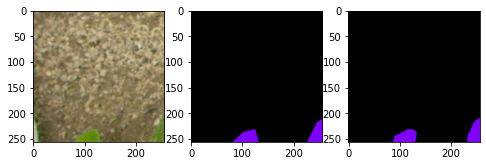

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(8, 8))
fig.show()
image, target = next(iterator)

image = image[0]
image.shape
target = target[0, ..., 0]

out_sigmoid = model.predict(x=tf.expand_dims(image, 0))

# Get predicted class as the index corresponding to the maximum value in the vector probability
# predicted_class = tf.cast(out_sigmoid > score_th, tf.int32)
# predicted_class = predicted_class[0, ..., 0]
predicted_class = tf.argmax(out_sigmoid, -1)

out_sigmoid.shape

predicted_class = predicted_class[0, ...]

predicted_class.shape

# Assign colors (just for visualization)
target_img = np.zeros([target.shape[0], target.shape[1], 3])
prediction_img = np.zeros([target.shape[0], target.shape[1], 3])

target_img[np.where(target == 0)] = [0, 0, 0]
for i in range(1, 3):
  target_img[np.where(target == i)] = np.array(colors[i-1])[:3] * 255

prediction_img[np.where(predicted_class == 0)] = [0, 0, 0]
for i in range(1, 3):
  prediction_img[np.where(predicted_class == i)] = np.array(colors[i-1])[:3] * 255

ax[0].imshow(np.uint8(image))
ax[1].imshow(np.uint8(target_img))
ax[2].imshow(np.uint8(prediction_img))

fig.canvas.draw()
time.sleep(1)

In [ ]:
import json

def stitch_patch(patched_ma, i_h, i_w, h_stride=1, w_stride=1, channel=1, type = 'png'):
    """
        Takes source folder containing patches of Images and reconstruct the original image by recombining
        the patches using naive overlapping assumption without any smoothing and saves them in destination
        NOTE: Patch files should be named like patch_i_j where i = Image number eg. 1,2,3,4 and j = Patch number
              eg. 1,2,3,4 etc. i.e. patch_i_j represent jth patch of ith image
        Params: patched_ma -> list containing patches
                i_h      -> desired height
                i_w      -> desired width
                h_stride -> 1/overlap taken among adjacent patch along height eg. 0.5 for twice overlap
                w_stride -> 1/overlap taken among adjacent patch along width
                channel  -> number of channel in patches
                type     -> type of patch 'png', 'jpg', 'tif'
    """
        
    patches = patched_ma
 
    patch_height = 256
    patch_width  = 256

    orig_img_height = i_h
    orig_img_width  = i_w

    h_stride = int(h_stride*patch_height)
    w_stride = int(w_stride*patch_width)

    img_dtype = np.uint16
    image = np.zeros((orig_img_height, orig_img_width, channel), dtype = img_dtype)

    padding   = return_padding(image, patch_height, patch_width)
    
    image     = pad_image(image, patch_height, patch_width, channel,mode='constant')
    print('Image shape post padding: ')
    image.shape
    print('\n')
    h = 0
    w = 0
    patch_id = 0

    while h <= image.shape[0]-patch_height:
        w = 0
        while w <= image.shape[1]-patch_width:
            image[h:h+patch_height, w:w+patch_width, :] = np.maximum(patches[patch_id],image[h:h+patch_height, w:w+patch_width, :])
            w = w + w_stride
            patch_id+=1
        h = h+h_stride

    print("image size before final padding")
    print(image.shape)
    print("\n")
    
    
    if padding!=[(0, 0), (0, 0), (0, 0)]:
       image = image[padding[0][0]:-padding[0][1], padding[1][0]:-padding[1][1],:]

    print("FinalImage shape{}".format(image.shape))
    print("\n")
  

    return image

In [ ]:
test_dev_dir = '/content/drive/My Drive/Test_Dev/Roseau/Mais/Images'             #repeat for each subfolder. 

cropped_dir  = '/content/drive/My Drive/Cropped_overlapped_test/Roseau/Mais'

image_names  =os.listdir(test_dev_dir)

for image_name in image_names:

  img_path = os.path.join(test_dev_dir, image_name)

  image_name = image_name.replace('.jpeg','')

  os.mkdir(os.path.join(cropped_dir,image_name))

  save_dir=os.path.join(cropped_dir,image_name)

  # open and convert to array
  img = Image.open(img_path)
  img_array = np.array(img)

  patches, dic = create_patches(img_array, patch_height=256, patch_width=256, h_stride=0.5,w_stride=0.5)

  i = 0

  for data in patches:
    saved_name = image_name+'_'+str(i)+'.jpeg'
    img = Image.fromarray(data, 'RGB')
    img.save(os.path.join(save_dir,saved_name))
    i = i+1

In [ ]:
import os
import json
import numpy as np
from PIL import Image


def rle_encode(img):
    '''
    img: numpy array, 1 - foreground, 0 - background
    Returns run length as string formatted
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

    # The submission file will be a zip file containing the a
    # submission.json file.

    # It must have the following structure:

    # - image name (without any extension, e.g., png, jpg, etc.)
    #   - shape: shape of the original image as list [Height, Width]
    #   - team: team of the original image. One in {'Bipbip', 'Pead', 'Roseau', 'Weedelec'}
    #   - crop: crop of the original image. One in {'Haricot', 'Mais'}
    #   - segmentation: prediction (as a dict)
    #     - crop: RLE encoded crop segmentation (no weed)
    #     - weed: RLE encoded weed segmentation (no crop)

    # Please refer to the folder structure of the given dataset to fill
    # the team and crop keys.

    # EXAMPLE:

    # Suppose that the numpy array generated with the
    # 'read_mask_example.py' script is the output of your segmentation model.
    # In addition, suppose that the team and crop of the segmented image
    # are 'Bipbip' and 'Haricot', respectively.
    # Then, in the following an example of submission file.

submission_dict = {}

test_dev_dir = '/content/drive/My Drive/Cropped_overlapped_test/Bipbip'
true_image_dir = '/content/drive/My Drive/Test_Dev/Bipbip'

team_dir=test_dev_dir
true_team_dir=true_image_dir

crop_names = os.listdir(team_dir)
crop_names

for crop_name in crop_names:
  
    crop_dir = os.path.join(team_dir, crop_name)
    true_crop_dir = os.path.join(true_team_dir, crop_name,'Images')
    test_names = os.listdir(crop_dir)
    test_names
  
    for test_name in test_names:
      
      img_folder = test_name
      img_path = os.path.join(crop_dir,img_folder)
      true_img_path=os.path.join(true_crop_dir,test_name)
      
      patched_masks = []

      for each_crop in os.listdir(img_path):
        img =Image.open(os.path.join(img_path,each_crop))
        img_array = np.array(img)
        img_size = img_array.shape
        img_tensor = tf.convert_to_tensor(img_array)
        img_tensor = tf.cast(img_tensor,tf.float32)
        out_sigmoid = model.predict(x=tf.expand_dims(img_tensor,0))
        predicted_class = tf.argmax(out_sigmoid, -1)[0,...]                        #tensor 256x256
        predicted_class = tf.expand_dims(predicted_class,-1)  
        
        patched_masks.append(predicted_class)

      true_image=Image.open(true_img_path)
      true_img_array = np.array(true_image)
      true_img_size = true_img_array.shape
      mask_arr = stitch_patch(patched_ma=patched_masks,
                  i_h = true_img_size[0],
                  i_w = true_img_size[1], 
                  h_stride = 0.5, w_stride = 0.5, 
                  channel=1, type = 'png')
      print("Mask_arr shape: ")
      mask_arr.shape
      print('\n')
      
      mask_arr = mask_arr[...,0]
      mask_arr = np.array(mask_arr)

      np.unique(mask_arr)

      # fill the dictionary

      test_name = test_name.replace('.jpg','')
      test_name = test_name.replace('.png','')
      submission_dict[test_name] = {}
      submission_dict[test_name]['shape'] = mask_arr.shape
      submission_dict[test_name]['team'] = team_name
      submission_dict[test_name]['crop'] = crop_name
      submission_dict[test_name]['segmentation'] = {}

      # RLE encoding
      # crop
      rle_encoded_crop = rle_encode(mask_arr == 1)
      # weed
      rle_encoded_weed = rle_encode(mask_arr == 2)

      submission_dict[test_name]['segmentation']['crop'] = rle_encoded_crop
      submission_dict[test_name]['segmentation']['weed'] = rle_encoded_weed

# Finally, save the results into the submission.json file
with open('/content/drive/MyDrive/BipbipDataset/Haricot/Predictions/submission.json', 'w') as f:
  json.dump(submission_dict, f)








      




     

      